In [1]:
import librosa
import numpy as np

In [2]:
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
import librosa
import librosa.display
import scipy.io

In [3]:
lambani_bona = scipy.io.loadmat('../matFiles/lambani_bona_withFilename.mat')
lambani_wg = scipy.io.loadmat('../matFiles/lambani_waveglow_withFilename.mat')
lambani_hifi = scipy.io.loadmat('../matFiles/lambani_hifi_withFilename.mat')

In [6]:
def findIndex(dict, filename):
    for i, arr in enumerate(dict['a'][0]):
        if(arr[0] == filename):
            return i

In [7]:
trip1_origIndex = findIndex(lambani_bona, '2.wav')
trip1_waveIndex = findIndex(lambani_wg, '1.wav')
trip1_hifiIndex = findIndex(lambani_hifi, '1.wav')

In [8]:
rootdir_orig = '/nas/rishith/datasets/iiit_datasets/1-10k/wavs/'
rootdir_wg = '/nas/rishith/datasets/iiit_datasets/lambani_waveglow1-20230818T143400Z-001/lambani_waveglow1/'
rootdir_hifi = '/nas/rishith/datasets/iiit_datasets/lambani_hifi_-20230818T142950Z-001/lambani_hifi_/'

triplet1 = {
    'original' : {
        'wav' : librosa.load(rootdir_orig+lambani_bona['a'][0][trip1_origIndex][0], sr=8000)[0],
        'vops': lambani_bona['c'][0][trip1_origIndex][0]
    },
    'waveglow':{
        'wav' : librosa.load(rootdir_wg+lambani_wg['a'][0][trip1_waveIndex][0], sr=8000)[0],
        'vops': lambani_wg['c'][0][trip1_waveIndex][0]
    },
    'hifigan':{
        'wav' : librosa.load(rootdir_hifi+lambani_hifi['a'][0][trip1_hifiIndex][0], sr=8000)[0],
        'vops': lambani_hifi['c'][0][trip1_hifiIndex][0]
    }    
}

In [3]:
import sys
sys.path.insert(0, '../amplitude-modulation-analysis-module/')
from am_analysis import am_analysis as ama

ModuleNotFoundError: No module named 'am_analysis'

In [69]:
def modulation_spectogram_from_wav(audio_data,fs):
    x=audio_data
    x = x / np.max(x)
    win_size_sec = 0.015 
    win_shft_sec = 0.005  
    stft_modulation_spectrogram = ama.strfft_modulation_spectrogram(x, fs, win_size = round(win_size_sec*fs), win_shift = round(win_shft_sec*fs), channel_names = ['Modulation Spectrogram'])
    X_plot=ama.plot_modulation_spectrogram_data(stft_modulation_spectrogram, 0 , modf_range = np.array([0,20]), c_range =  np.array([-90, -50]))
    return X_plot

def load_data(segment, sr=8000):
    linear_spect = modulation_spectogram_from_wav(segment,sr)
    mag_T = linear_spect

    mu = np.mean(mag_T)
    std = np.std(mag_T)
    return (mag_T - mu) / (std + 1e-5)

def getFeatures(path, vops):
    fs = 8000
    ms50 = int(0.05 * fs)
    features = np.zeros((1,61,10))
    audio, _ = librosa.load(path, sr=fs)
    fileVopIndices = vops.split(',')
    fileVopIndices = [ int(x) for x in fileVopIndices ]
    n = 10
    if(len(fileVopIndices) < n):
        fileVopIndices = repeat_padding(fileVopIndices)
    else:
        fileVopIndices = fileVopIndices[:n]
    for vopIndex in fileVopIndices:
        print(vopIndex)
        startPoint = max(0, vopIndex - ms50)
        print(np.shape(audio))
        print(vopIndex + ms50)
        endPoint = min(np.shape(audio)[0], vopIndex + ms50)
        print(startPoint)
        print(endPoint)
        segment100ms = audio[startPoint: endPoint]
        if((endPoint - startPoint) < 2*ms50):
            print(endPoint - startPoint)
            segment100ms = zero_padding(segment100ms, 2*ms50)
        ms = load_data(segment100ms)
        features = np.concatenate((features, ms.reshape(1, 61, 10)), axis = 0)
    return features[1:, :]

In [11]:
path = rootdir_orig+lambani_bona['a'][0][trip1_origIndex][0]
vops = lambani_bona['c'][0][trip1_origIndex][0]
print(path)
print(vops)

/nas/rishith/datasets/iiit_datasets/1-10k/wavs/2.wav
[0 0 0 ... 0 0 0]


In [12]:
def getIndices(vop):
    indices = [ind for ind, ele in enumerate(vop) if ele == 1]
    return indices

indicesTrip1_orig = getIndices(vops)

In [13]:
print(indicesTrip1_orig)

[325, 1182, 2432, 3449, 4808, 7226, 7982, 8595, 10634, 12405]


In [67]:
def zero_padding(segment, n):
    print(len(segment))
    length = len(segment)
    result = np.zeros(n)
    print(result.shape)
    result[:length] = segment
    return result

In [30]:
def repeat_padding(originalVops, n=10):
    paddedVops = []
    noOfVops = len(originalVops)
    
    if(noOfVops < n):
        i = 0
        paddedVops = originalVops
        while (noOfVops < n):
            paddedVops.append(originalVops[i])
            noOfVops += 1
            i += 1
            if(i == noOfVops):
                i = 0
    
    return paddedVops

In [31]:
orig = [325, 1182, 2432, 3449, 4808, 7226]
op = repeat_padding(orig, 10)
print(op)

[325, 1182, 2432, 3449, 4808, 7226, 325, 1182, 2432, 3449]


In [32]:
orig = [325, 1182]
op = repeat_padding(orig, 10)
print(op)

[325, 1182, 325, 1182, 325, 1182, 325, 1182, 325, 1182]


In [46]:
orig = np.array([325, 1182])
print(orig.shape)
zero_padding(orig, 10)

(2,)
[ 325 1182]


array([ 325., 1182.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.])

325
(14537,)
725
0
725
725
725
(800,)
1182
(14537,)
1582
782
1582
2432
(14537,)
2832
2032
2832
3449
(14537,)
3849
3049
3849
4808
(14537,)
5208
4408
5208
7226
(14537,)
7626
6826
7626
7982
(14537,)
8382
7582
8382
8595
(14537,)
8995
8195
8995
10634
(14537,)
11034
10234
11034
12405
(14537,)
12805
12005
12805


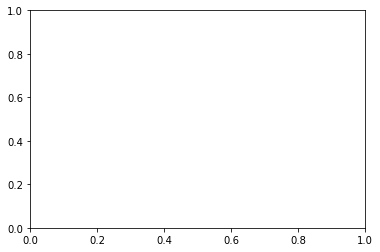

In [88]:
vops1 = '325,1182,2432,3449,4808,7226,7982,8595,10634,12405'
a = getFeatures(path, vops1)

In [89]:
# a.shape

(10, 61, 10)

In [75]:
# a.reshape(61, -1).shape

(61, 100)

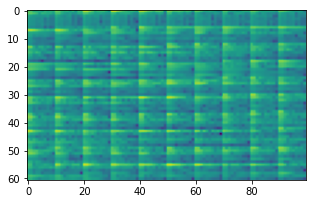

In [87]:
# plt.figure(figsize=(5,10))
# plt.imshow(a.reshape(61, -1))
# plt.show()

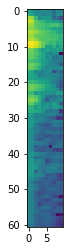

In [78]:
plt.figure()
plt.imshow(a[1,:,:])

In [90]:
a.shape

(10, 61, 10)

In [91]:
b = a.swapaxes(0, 1).reshape(a.shape[1], -1)

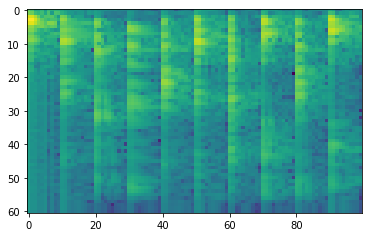

In [92]:
plt.figure()
plt.imshow(b)
plt.show()